In [1]:
import pandas as pd
import numpy as np
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

In [205]:
aol_query_data = pd.read_csv("user-ct-test-collection-02.txt", sep="\t", on_bad_lines='skip')

In [206]:
aol_query_data

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,479,family guy,2006-03-01 16:01:20,NaN,NaN
1,479,also sprach zarathustra,2006-03-02 14:48:55,NaN,NaN
2,479,family guy movie references,2006-03-03 22:37:46,1.0,http://www.familyguyfiles.com
3,479,top grossing movies of all time,2006-03-03 22:42:42,1.0,http://movieweb.com
4,479,top grossing movies of all time,2006-03-03 22:42:42,2.0,http://www.imdb.com
...,...,...,...,...,...
3614501,24969423,my space. com,2006-05-31 19:03:32,2.0,http://music.myspace.com
3614502,24969423,my space.com,2006-05-31 19:12:00,NaN,NaN
3614503,24969423,my space.com 3131560415,2006-05-31 19:12:25,NaN,NaN
3614504,24969423,jennifer craford my space.com,2006-05-31 19:15:02,NaN,NaN


In [3]:
aol_query_data[['Date', 'Time']] = aol_query_data.QueryTime.str.split(" ", expand = True)

In [4]:
aol_query_data['Query'].isnull().sum()

129

In [5]:
aol_query_data['Date'].isnull().sum()

0

In [6]:
aol_query_data['Query'].replace('', np.nan, inplace=True)

In [7]:
aol_query_data['Query'].replace('-', np.nan, inplace=True)

In [8]:
aol_query_data.dropna(subset=['Query'], inplace=True)

In [9]:
aol_query_data.drop(['AnonID', 'ItemRank', 'ClickURL', 'Time', 'QueryTime'], axis=1, inplace=True)

In [10]:
aol_query_data.reset_index(drop="True", inplace=True)

In [11]:
aol_query_data

,Query,Date
0,family guy,2006-03-01
1,also sprach zarathustra,2006-03-02
2,family guy movie references,2006-03-03
3,top grossing movies of all time,2006-03-03
4,top grossing movies of all time,2006-03-03
...,...,...
3515818,my space. com,2006-05-31
3515819,my space.com,2006-05-31
3515820,my space.com 3131560415,2006-05-31
3515821,jennifer craford my space.com,2006-05-31


In [12]:
aol_query_frequency = aol_query_data.groupby(['Date', 'Query']).size().reset_index(name='freq')

In [13]:
aol_query_frequency = aol_query_frequency.sort_values(by=['Date', "freq"], ascending=[True, False]).reset_index(drop="True")

In [14]:
aol_query_frequency["Querylen"] = aol_query_frequency["Query"].str.len()

In [15]:
aol_query_frequency

,Date,Query,freq,Querylen
0,2006-03-01,google,400,6
1,2006-03-01,yahoo,197,5
2,2006-03-01,ebay,163,4
3,2006-03-01,yahoo.com,127,9
4,2006-03-01,google.com,120,10
...,...,...,...,...
1758999,2006-05-31,zip codes.com,1,13
1759000,2006-05-31,zipcodes,1,8
1759001,2006-05-31,zone,1,4
1759002,2006-05-31,zone.com,1,8


In [16]:
characters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm','n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
              'y', 'z','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '.', '-', "'", '&', ';', 'nv']

In [17]:
character_ids = {}
i = 1
for char in characters:
    character_ids[char] = i
    i = i + 1

In [18]:
def get_characters(string):
    return list(string)

In [19]:
def get_char_id(charlist):
    char_ids = []
    for char in charlist:
        if char in character_ids.keys():
            char_ids.append(character_ids[char])
        else:
            char_ids.append(0)
    return char_ids

In [20]:
def pad_list(x):
    if len(x) < 60:
        return x + [0] * (60 - len(x))
    else:
        return x[:60]

In [21]:
def list_to_array(x):
    return np.array(x)

In [22]:
aol_query_frequency["Querychar"] = aol_query_frequency["Query"].apply(get_characters)

In [23]:
aol_query_frequency["charIDs"] = aol_query_frequency["Querychar"].apply(get_char_id)

In [24]:
aol_query_frequency["charIDs"] = aol_query_frequency["charIDs"].apply(pad_list)

In [25]:
dateRange = (aol_query_frequency['Date'] >= '2006-03-01') & (aol_query_frequency['Date'] <= '2006-03-08')

In [27]:
dateReq = (aol_query_frequency['Date'] == '2006-03-09')

In [28]:
dateTest = (aol_query_frequency['Date'] >= '2006-03-16') & (aol_query_frequency['Date'] <= '2006-03-21')

In [29]:
aol_frequency_train = aol_query_frequency.loc[dateRange]

In [30]:
aol_freq_train = aol_query_frequency.loc[dateRange2]

In [31]:
aol_frequency_validate = aol_query_frequency.loc[dateReq]

In [32]:
aol_frequency_test = aol_query_frequency.loc[dateTest]

In [33]:
aol_frequency_test.reset_index(drop=True, inplace=True)

In [34]:
def get_data_aol_feat(data):
    query_char_ids = np.stack(data['charIDs'].apply(list_to_array))
    counts  = data['freq']
    x = query_char_ids
    y = np.array(counts)
    assert len(x) == len(y)
    return x, y

In [37]:
x_train, y_train = get_data_aol_feat(aol_frequency_train)

In [38]:
len(y_train)

183713

In [39]:
x_val, y_val = get_data_aol_feat(aol_frequency_validate)

In [207]:
len(y_val)

22652

In [40]:
x_test, y_test = get_data_aol_feat(aol_frequency_test)

In [41]:
y_train = np.log(y_train)

In [208]:
len(y_test)

135360

In [42]:
y_val = np.log(y_val)

In [43]:
inputs = Input(name='inputs', shape=(60,))
layer = Embedding(input_dim=44, output_dim=64)(inputs)
layer = SimpleRNN(256, return_sequences=True)(layer)
layer = LSTM(256)(layer)
layer = Dense(32, activation='LeakyReLU')(layer)
layer = Dense(1, name='out_layer')(layer)
layer = Activation('relu')(layer)

model = Model(inputs=inputs, outputs=layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 64)            2816      
                                                                 
 simple_rnn (SimpleRNN)      (None, 60, 256)           82176     
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 out_layer (Dense)           (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0     

In [45]:
Aol_model = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val), verbose=1)

Epoch 1/30
1436/1436 [==============================] - 65s 43ms/step - loss: 0.3867 - val_loss: 0.3783
Epoch 2/30
1436/1436 [==============================] - 61s 43ms/step - loss: 0.3843 - val_loss: 0.3776
Epoch 3/30
1436/1436 [==============================] - 60s 42ms/step - loss: 0.3839 - val_loss: 0.3791
Epoch 4/30
1436/1436 [==============================] - 60s 42ms/step - loss: 0.3836 - val_loss: 0.3772
Epoch 5/30
1436/1436 [==============================] - 62s 43ms/step - loss: 0.3830 - val_loss: 0.3772
Epoch 6/30
1436/1436 [==============================] - 63s 44ms/step - loss: 0.3829 - val_loss: 0.3788
Epoch 7/30
1436/1436 [==============================] - 60s 42ms/step - loss: 0.3824 - val_loss: 0.3764
Epoch 8/30
1436/1436 [==============================] - 59s 41ms/step - loss: 0.3818 - val_loss: 0.3774
Epoch 9/30
1436/1436 [==============================] - 74s 52ms/step - loss: 0.3814 - val_loss: 0.3771
Epoch 10/30
1436/1436 [==============================] - 62s 43m

In [46]:
model.save_weights('model_weights.h5')

In [47]:
new_inputs = Input(name='inputs', shape=(60,))
new_layer = Embedding(input_dim=44, output_dim=64)(new_inputs)
new_layer = LSTM(256, return_sequences=True)(new_layer)
new_layer = LSTM(256 , return_sequences=True)(new_layer)
new_layer = LSTM(256)(new_layer)
new_layer = Dense(32, activation='relu')(new_layer)
new_layer = Dense(1, name='out_layer')(new_layer)
new_layer = Activation('relu')(new_layer)

new_model = Model(inputs=new_inputs, outputs=new_layer)
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

In [48]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 60)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 60, 64)            2816      
                                                                 
 lstm_1 (LSTM)               (None, 60, 256)           328704    
                                                                 
 lstm_2 (LSTM)               (None, 60, 256)           525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 out_layer (Dense)           (None, 1)                 33  

In [49]:
new_Aol_model = new_model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), verbose=1)

Epoch 1/40
1436/1436 [==============================] - 26s 17ms/step - loss: 0.3895 - val_loss: 0.3788
Epoch 2/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3849 - val_loss: 0.3783
Epoch 3/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3843 - val_loss: 0.3776
Epoch 4/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3843 - val_loss: 0.3795
Epoch 5/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3838 - val_loss: 0.3786
Epoch 6/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3836 - val_loss: 0.3774
Epoch 7/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3834 - val_loss: 0.3777
Epoch 8/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3846 - val_loss: 0.3792
Epoch 9/40
1436/1436 [==============================] - 24s 17ms/step - loss: 0.3840 - val_loss: 0.3788
Epoch 10/40
1436/1436 [==============================] - 24s 17m

In [50]:
new_model.save_weights('new_model_weights.h5')

In [51]:
model.load_weights('model_weights.h5')

In [52]:
new_model.load_weights('new_model_weights.h5')

In [53]:
out = model.predict(x_test)

4230/4230 [==============================] - 36s 8ms/step


In [54]:
new_out = new_model.predict(x_test)

4230/4230 [==============================] - 27s 6ms/step


In [55]:
out = np.exp(out)

In [56]:
new_out = np.exp(new_out)

In [57]:
len(new_out)

135360

In [59]:
class Node:
    def __init__(self, key=None, priority=None):
        self.key = key
        self.priority = priority
        self.left = None
        self.right = None

class Treap:
    def __init__(self):
        self.root = None
        self.comparisons = 0
        self.comparisons_insert = 0
        self.comparisons_search = 0
        self.comparisons_delete = 0

    def insert(self, key, priority):
        self.comparisons_insert = 0
        self.root, success = self._insert(self.root, key, priority)
        return success

    def _insert(self, node, key, priority):
        self.comparisons_insert += 1
        if node is None:
            return Node(key, priority), True

        if key == node.key:
            return node, False

        if key < node.key:
            node.left, success = self._insert(node.left, key, priority)
            if priority > node.priority:
                node = self._rotate_right(node)
            return node, success

        node.right, success = self._insert(node.right, key, priority)
        if priority > node.priority:
            node = self._rotate_left(node)
        return node, success

    def search(self, key):
        self.comparisons_search = 0
        node = self.root
        while node is not None:
            self.comparisons_search += 1
            if key == node.key:
                return node
            elif key < node.key:
                node = node.left
            else:
                node = node.right
        return None

    def delete(self, key):
        self.comparisons_delete = 0
        self.root, success = self._delete(self.root, key)
        return success

    def _delete(self, node, key):
        self.comparisons_delete += 1
        if node is None:
            return None, False

        if key == node.key:
            if node.left is None and node.right is None:
                return None, True
            elif node.left is None:
                return node.right, True
            elif node.right is None:
                return node.left, True
            elif node.left.priority > node.right.priority:
                node = self._rotate_right(node)
                node.right, success = self._delete(node.right, key)
            else:
                node = self._rotate_left(node)
                node.left, success = self._delete(node.left, key)
            return node, True

        if key < node.key:
            node.left, success = self._delete(node.left, key)
        else:
            node.right, success = self._delete(node.right, key)
        return node, success

    def successor(self, key):
        node = self.root
        succ = None
        while node is not None:
            self.comparisons += 1
            if node.key > key:
                succ = node
                node = node.left
            else:
                node = node.right
        return succ

    def _rotate_right(self, node):
        left_child = node.left
        node.left = left_child.right
        left_child.right = node
        return left_child

    def _rotate_left(self, node):
        right_child = node.right
        node.right = right_child.left
        right_child.left = node
        return right_child

In [60]:
old_model_treap1 = Treap()
old_model_treap2 = Treap()
old_model_treap3 = Treap()
old_model_treap4 = Treap()
old_model_treap5 = Treap()
old_model_treap6 = Treap()
old_model_treap7 = Treap()
old_model_treap8 = Treap()
old_model_treap9 = Treap()
old_model_treap10 = Treap()

In [80]:
new_model_treap1 = Treap()
new_model_treap2 = Treap()
new_model_treap3 = Treap()
new_model_treap4 = Treap()
new_model_treap5 = Treap()
new_model_treap6 = Treap()
new_model_treap7 = Treap()
new_model_treap8 = Treap()
new_model_treap9 = Treap()
new_model_treap10 = Treap()

In [62]:
search_list1 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:5000].index.to_list()
search_list2 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:10000].index.to_list()
search_list3 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:15000].index.to_list()
search_list4 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:20000].index.to_list()
search_list5 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:25000].index.to_list()
search_list6 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:30000].index.to_list()
search_list7 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:35000].index.to_list()
search_list8 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:40000].index.to_list()
search_list9 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:45000].index.to_list()
search_list10 = aol_frequency_test.sort_values(by="freq" , ascending=False)[:50000].index.to_list()

In [63]:
index1 = 5000
index2 = 10000
index3 = 15000
index4 = 20000
index5 = 25000
index6 = 30000
index7 = 35000
index8 = 40000
index9 = 45000
index10 = 50000

In [64]:
ins_index1 = 10000
ins_index2 = 20000
ins_index3 = 30000
ins_index4 = 40000
ins_index5 = 50000
ins_index6 = 60000
ins_index7 = 70000
ins_index8 = 80000
ins_index9 = 90000
ins_index10 = 100000

In [65]:
old_treap_comp1 = 0
old_treap_comp2 = 0
old_treap_comp3 = 0
old_treap_comp4 = 0
old_treap_comp5 = 0
old_treap_comp6 = 0
old_treap_comp7 = 0
old_treap_comp8 = 0
old_treap_comp9 = 0
old_treap_comp10 = 0

In [66]:
old_treap_table = []
for i in range(1, ins_index1):
    old_model_treap1.insert(i, out[i])
    old_treap_comp1 += old_model_treap1.comparisons_insert
old_treap_table.append([ins_index1, old_treap_comp1])
for i in range(1, ins_index2):
    old_model_treap2.insert(i, out[i])
    old_treap_comp2 += old_model_treap2.comparisons_insert
old_treap_table.append([ins_index2, old_treap_comp2])
for i in range(1, ins_index3):
    old_model_treap3.insert(i, out[i])
    old_treap_comp3 += old_model_treap3.comparisons_insert
old_treap_table.append([ins_index3, old_treap_comp3])
for i in range(1, ins_index4):
    old_model_treap4.insert(i, out[i])
    old_treap_comp4 += old_model_treap4.comparisons_insert
old_treap_table.append([ins_index4, old_treap_comp4])
for i in range(1, ins_index5):
    old_model_treap5.insert(i, out[i])
    old_treap_comp5 += old_model_treap5.comparisons_insert
old_treap_table.append([ins_index5, old_treap_comp5])
for i in range(1, ins_index6):
    old_model_treap6.insert(i, out[i])
    old_treap_comp6 += old_model_treap6.comparisons_insert
old_treap_table.append([ins_index6, old_treap_comp6])
for i in range(1, ins_index7):
    old_model_treap7.insert(i, out[i])
    old_treap_comp7 += old_model_treap7.comparisons_insert
old_treap_table.append([ins_index7, old_treap_comp7])
for i in range(1, ins_index8):
    old_model_treap8.insert(i, out[i])
    old_treap_comp8 += old_model_treap8.comparisons_insert
old_treap_table.append([ins_index8, old_treap_comp8])
for i in range(1, ins_index9):
    old_model_treap9.insert(i, out[i])
    old_treap_comp9 += old_model_treap9.comparisons_insert
old_treap_table.append([ins_index9, old_treap_comp9])
for i in range(1, ins_index10):
    old_model_treap10.insert(i, out[i])
    old_treap_comp10 += old_model_treap10.comparisons_insert
old_treap_table.append([ins_index10, old_treap_comp10])

In [95]:
old_treap_search1 = 0
old_treap_search2 = 0
old_treap_search3 = 0
old_treap_search4 = 0
old_treap_search5 = 0
old_treap_search6 = 0
old_treap_search7 = 0
old_treap_search8 = 0
old_treap_search9 = 0
old_treap_search10 = 0

In [96]:
old_model_search_table = []
for element in search_list1:
    old_model_treap1.search(element)
    old_treap_search1 += old_model_treap1.comparisons_search
old_model_search_table.append([len(search_list1), old_treap_search1])
for element in search_list2:
    old_model_treap2.search(element)
    old_treap_search2 += old_model_treap2.comparisons_search
old_model_search_table.append([len(search_list2), old_treap_search2])
for element in search_list3:
    old_model_treap3.search(element)
    old_treap_search3 += old_model_treap3.comparisons_search
old_model_search_table.append([len(search_list3), old_treap_search3])
for element in search_list4:
    old_model_treap4.search(element)
    old_treap_search4 += old_model_treap4.comparisons_search
old_model_search_table.append([len(search_list4), old_treap_search4])
for element in search_list5:
    old_model_treap5.search(element)
    old_treap_search5 += old_model_treap5.comparisons_search
old_model_search_table.append([len(search_list5), old_treap_search5])
for element in search_list6:
    old_model_treap6.search(element)
    old_treap_search6 += old_model_treap6.comparisons_search
old_model_search_table.append([len(search_list6), old_treap_search6])
for element in search_list7:
    old_model_treap7.search(element)
    old_treap_search7 += old_model_treap7.comparisons_search
old_model_search_table.append([len(search_list7), old_treap_search7])
for element in search_list8:
    old_model_treap8.search(element)
    old_treap_search8 += old_model_treap8.comparisons_search
old_model_search_table.append([len(search_list8), old_treap_search8])
for element in search_list9:
    old_model_treap9.search(element)
    old_treap_search9 += old_model_treap9.comparisons_search
old_model_search_table.append([len(search_list9), old_treap_search9])
for element in search_list10:
    old_model_treap10.search(element)
    old_treap_search10 += old_model_treap10.comparisons_search
old_model_search_table.append([len(search_list10), old_treap_search10])

In [81]:
new_treap_comp1 = 0
new_treap_comp2 = 0
new_treap_comp3 = 0
new_treap_comp4 = 0
new_treap_comp5 = 0
new_treap_comp6 = 0
new_treap_comp7 = 0
new_treap_comp8 = 0
new_treap_comp9 = 0
new_treap_comp10 = 0

In [82]:
new_treap_table = []
for i in range(1, ins_index1):
    new_model_treap1.insert(i, new_out[i])
    new_treap_comp1 += new_model_treap1.comparisons_insert
new_treap_table.append([ins_index1, new_treap_comp1])
for i in range(1, ins_index2):
    new_model_treap2.insert(i, new_out[i])
    new_treap_comp2 += new_model_treap2.comparisons_insert
new_treap_table.append([ins_index2, new_treap_comp2])
for i in range(1, ins_index3):
    new_model_treap3.insert(i, new_out[i])
    new_treap_comp3 += new_model_treap3.comparisons_insert
new_treap_table.append([ins_index3, new_treap_comp3])
for i in range(1, ins_index4):
    new_model_treap4.insert(i, new_out[i])
    new_treap_comp4 += new_model_treap4.comparisons_insert
new_treap_table.append([ins_index4, new_treap_comp4])
for i in range(1, ins_index5):
    new_model_treap5.insert(i, new_out[i])
    new_treap_comp5 += new_model_treap5.comparisons_insert
new_treap_table.append([ins_index5, new_treap_comp5])
for i in range(1, ins_index6):
    new_model_treap6.insert(i, new_out[i])
    new_treap_comp6 += new_model_treap6.comparisons_insert
new_treap_table.append([ins_index6, new_treap_comp6])
for i in range(1, ins_index7):
    new_model_treap7.insert(i, new_out[i])
    new_treap_comp7 += new_model_treap7.comparisons_insert
new_treap_table.append([ins_index7, new_treap_comp7])
for i in range(1, ins_index8):
    new_model_treap8.insert(i, new_out[i])
    new_treap_comp8 += new_model_treap8.comparisons_insert
new_treap_table.append([ins_index8, new_treap_comp8])
for i in range(1, ins_index9):
    new_model_treap9.insert(i, new_out[i])
    new_treap_comp9 += new_model_treap9.comparisons_insert
new_treap_table.append([ins_index9, new_treap_comp9])
for i in range(1, ins_index10):
    new_model_treap10.insert(i, new_out[i])
    new_treap_comp10 += new_model_treap10.comparisons_insert
new_treap_table.append([ins_index10, new_treap_comp10])

In [153]:
new_treap_search1 = 0
new_treap_search2 = 0
new_treap_search3 = 0
new_treap_search4 = 0
new_treap_search5 = 0
new_treap_search6 = 0
new_treap_search7 = 0
new_treap_search8 = 0
new_treap_search9 = 0
new_treap_search10 = 0

In [154]:
new_model_search_table = []
for element in search_list1:
    new_model_treap1.search(element)
    new_treap_search1 += new_model_treap1.comparisons_search
new_model_search_table.append([len(search_list1), new_treap_search1])
for element in search_list2:
    new_model_treap2.search(element)
    new_treap_search2 += new_model_treap2.comparisons_search
new_model_search_table.append([len(search_list2), new_treap_search2])
for element in search_list3:
    new_model_treap3.search(element)
    new_treap_search3 += new_model_treap3.comparisons_search
new_model_search_table.append([len(search_list3), new_treap_search3])
for element in search_list4:
    new_model_treap4.search(element)
    new_treap_search4 += new_model_treap4.comparisons_search
new_model_search_table.append([len(search_list4), new_treap_search4])
for element in search_list5:
    new_model_treap5.search(element)
    new_treap_search5 += new_model_treap5.comparisons_search
new_model_search_table.append([len(search_list5), new_treap_search5])
for element in search_list6:
    new_model_treap6.search(element)
    new_treap_search6 += new_model_treap6.comparisons_search
new_model_search_table.append([len(search_list6), new_treap_search6])
for element in search_list7:
    new_model_treap7.search(element)
    new_treap_search7 += new_model_treap7.comparisons_search
new_model_search_table.append([len(search_list7), new_treap_search7])
for element in search_list8:
    new_model_treap8.search(element)
    new_treap_search8 += new_model_treap8.comparisons_search
new_model_search_table.append([len(search_list8), new_treap_search8])
for element in search_list9:
    new_model_treap9.search(element)
    new_treap_search9 += new_model_treap9.comparisons_search
new_model_search_table.append([len(search_list9), new_treap_search9])
for element in search_list10:
    new_model_treap10.search(element)
    new_treap_search10 += new_model_treap10.comparisons_search
new_model_search_table.append([len(search_list10), new_treap_search10])

In [67]:
import random

class Node:
    def __init__(self, key=None, priority=None):
        self.key = key
        self.priority = priority
        self.left = None
        self.right = None

class RandomTreap:
    def __init__(self):
        self.root = None
        self.comparisons = 0
        self.comparisons_search = 0
        self.comparisons_delete = 0

    def insert(self, key):
        self.comparisons_insert = 0
        priority = random.randint(1, 20000)
        self.root, success = self._insert(self.root, key, priority)
        return success

    def _insert(self, node, key, priority):
        self.comparisons_insert += 1
        if node is None:
            return Node(key, priority), True

        if key == node.key:
            return node, False

        if key < node.key:
            node.left, success = self._insert(node.left, key, priority)
            if priority > node.priority:
                node = self._rotate_right(node)
            return node, success

        node.right, success = self._insert(node.right, key, priority)
        if priority > node.priority:
            node = self._rotate_left(node)
        return node, success

    def search(self, key):
        self.comparisons_search = 0
        node = self.root
        while node is not None:
            self.comparisons_search += 1
            if key == node.key:
                return node
            elif key < node.key:
                node = node.left
            else:
                node = node.right
        return None

    def delete(self, key):
        self.comparisons_delete = 0
        self.root, success = self._delete(self.root, key)
        return success

    def _delete(self, node, key):
        self.comparisons_delete +=1
        if node is None:
            return None, False

        if key == node.key:
            if node.left is None and node.right is None:
                return None, True
            elif node.left is None:
                return node.right, True
            elif node.right is None:
                return node.left, True
            elif node.left.priority > node.right.priority:
                node = self._rotate_right(node)
                node.right, success = self._delete(node.right, key)
            else:
                node = self._rotate_left(node)
                node.left, success = self._delete(node.left, key)
            return node, True

        if key < node.key:
            node.left, success = self._delete(node.left, key)
        else:
            node.right, success = self._delete(node.right, key)
        return node, success

    def successor(self, key):
        node = self.root
        succ = None
        while node is not None:
            self.comparisons += 1
            if node.key > key:
                succ = node
                node = node.left
            else:
                node = node.right
        return succ

    def _rotate_right(self, node):
        left_child = node.left
        node.left = left_child.right
        left_child.right = node
        return left_child

    def _rotate_left(self, node):
        right_child = node.right
        node.right = right_child.left
        right_child.left = node
        return right_child

In [68]:
classic_treap1 = RandomTreap()
classic_treap2 = RandomTreap()
classic_treap3 = RandomTreap()
classic_treap4 = RandomTreap()
classic_treap5 = RandomTreap()
classic_treap6 = RandomTreap()
classic_treap7 = RandomTreap()
classic_treap8 = RandomTreap()
classic_treap9 = RandomTreap()
classic_treap10 = RandomTreap()

In [69]:
classic_treap_comp1 = 0
classic_treap_comp2 = 0
classic_treap_comp3 = 0
classic_treap_comp4 = 0
classic_treap_comp5 = 0
classic_treap_comp6 = 0
classic_treap_comp7 = 0
classic_treap_comp8 = 0
classic_treap_comp9 = 0
classic_treap_comp10 = 0

In [71]:
classic_treap_table = []
for i in range(1, ins_index1):
    classic_treap1.insert(i)
    classic_treap_comp1 += classic_treap1.comparisons_insert
classic_treap_table.append([ins_index1, classic_treap_comp1])
for i in range(1, ins_index2):
    classic_treap2.insert(i)
    classic_treap_comp2 += classic_treap2.comparisons_insert
classic_treap_table.append([ins_index2, classic_treap_comp2])
for i in range(1, ins_index3):
    classic_treap3.insert(i)
    classic_treap_comp3 += classic_treap3.comparisons_insert
classic_treap_table.append([ins_index3, classic_treap_comp3])
for i in range(1, ins_index4):
    classic_treap4.insert(i)
    classic_treap_comp4 += classic_treap4.comparisons_insert
classic_treap_table.append([ins_index4, classic_treap_comp4])
for i in range(1, ins_index5):
    classic_treap5.insert(i)
    classic_treap_comp5 += classic_treap5.comparisons_insert
classic_treap_table.append([ins_index5, classic_treap_comp5])
for i in range(1, ins_index6):
    classic_treap6.insert(i)
    classic_treap_comp6 += classic_treap6.comparisons_insert
classic_treap_table.append([ins_index6, classic_treap_comp6])
for i in range(1, ins_index7):
    classic_treap7.insert(i)
    classic_treap_comp7 += classic_treap7.comparisons_insert
classic_treap_table.append([ins_index7, classic_treap_comp7])
for i in range(1, ins_index8):
    classic_treap8.insert(i)
    classic_treap_comp8 += classic_treap8.comparisons_insert
classic_treap_table.append([ins_index8, classic_treap_comp8])
for i in range(1, ins_index9):
    classic_treap9.insert(i)
    classic_treap_comp9 += classic_treap9.comparisons_insert
classic_treap_table.append([ins_index9, classic_treap_comp9])
for i in range(1, ins_index10):
    classic_treap10.insert(i)
    classic_treap_comp10 += classic_treap10.comparisons_insert
classic_treap_table.append([ins_index10, classic_treap_comp10])

In [99]:
classic_treap_search1 = 0
classic_treap_search2 = 0
classic_treap_search3 = 0
classic_treap_search4 = 0
classic_treap_search5 = 0
classic_treap_search6 = 0
classic_treap_search7 = 0
classic_treap_search8 = 0
classic_treap_search9 = 0
classic_treap_search10 = 0

In [100]:
classic_treap_search_table = []
for element in search_list1:
    classic_treap1.search(element)
    new_treap_search1 += classic_treap1.comparisons_search
classic_treap_search_table.append([len(search_list1), new_treap_search1])
for element in search_list2:
    classic_treap2.search(element)
    new_treap_search2 += classic_treap2.comparisons_search
classic_treap_search_table.append([len(search_list2), new_treap_search2])
for element in search_list3:
    classic_treap3.search(element)
    new_treap_search3 += classic_treap3.comparisons_search
classic_treap_search_table.append([len(search_list3), new_treap_search3])
for element in search_list4:
    classic_treap4.search(element)
    new_treap_search4 += classic_treap4.comparisons_search
classic_treap_search_table.append([len(search_list4), new_treap_search4])
for element in search_list5:
    classic_treap5.search(element)
    new_treap_search5 += classic_treap5.comparisons_search
classic_treap_search_table.append([len(search_list5), new_treap_search5])
for element in search_list6:
    classic_treap6.search(element)
    new_treap_search6 += classic_treap6.comparisons_search
classic_treap_search_table.append([len(search_list6), new_treap_search6])
for element in search_list7:
    classic_treap7.search(element)
    new_treap_search7 += classic_treap7.comparisons_search
classic_treap_search_table.append([len(search_list7), new_treap_search7])
for element in search_list8:
    classic_treap8.search(element)
    new_treap_search8 += classic_treap8.comparisons_search
classic_treap_search_table.append([len(search_list8), new_treap_search8])
for element in search_list9:
    classic_treap9.search(element)
    new_treap_search9 += classic_treap9.comparisons_search
classic_treap_search_table.append([len(search_list9), new_treap_search9])
for element in search_list10:
    classic_treap10.search(element)
    new_treap_search10 += classic_treap10.comparisons_search
classic_treap_search_table.append([len(search_list10), new_treap_search10])

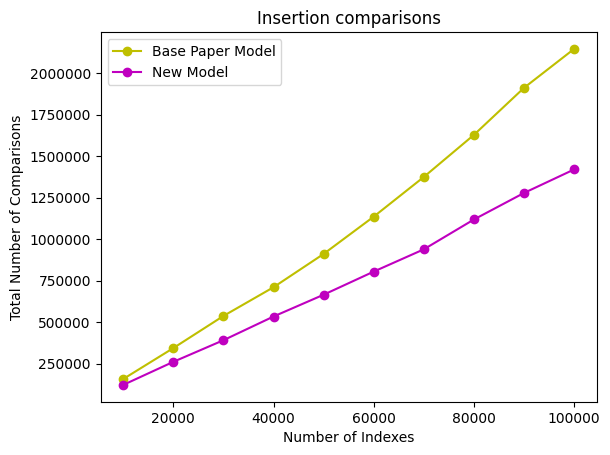

In [192]:
import matplotlib.pyplot as plt

x11 = [d[0] for d in old_treap_table]
y11 = [d[1] for d in old_treap_table]
x21 = [d[0] for d in new_treap_table]
y21 = [d[1] for d in new_treap_table]
x31 = [d[0] for d in classic_treap_table]
y31 = [d[1] for d in classic_treap_table]

plt.plot(x11, y11, "-yo",label='Base Paper Model')
plt.plot(x21, y21, "-mo",label='New Model')

plt.xlabel('Number of Indexes')
plt.ylabel('Total Number of Comparisons')
plt.title('Insertion comparisons')
plt.ticklabel_format(style='plain')
plt.legend()

plt.show()

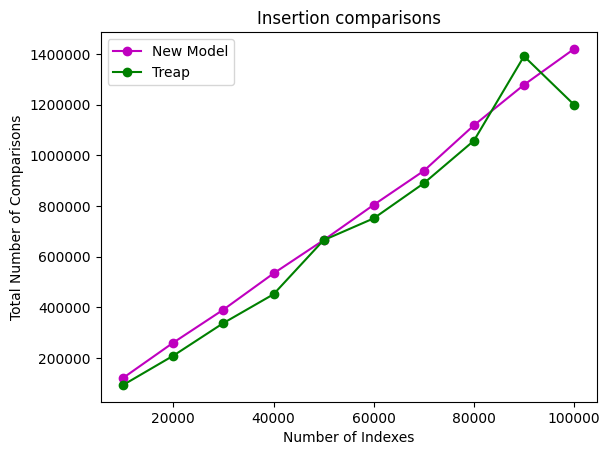

In [190]:
plt.plot(x21, y21, "-mo", label='New Model')
plt.plot(x31, y31, "-go" , label='Treap')

plt.xlabel('Number of Indexes')
plt.ylabel('Total Number of Comparisons')
plt.title('Insertion comparisons')
plt.ticklabel_format(style='plain')
plt.legend()

plt.show()

In [ ]:
total_comparisons = sum([d[1] for d in elements_graph])
average_comparisons = total_comparisons/len(search_list)
print(total_comparisons)
print(round(average_comparisons, 2))

In [ ]:
n_total_comparisons = sum([d[1] for d in new_elements_graph])
n_average_comparisons = n_total_comparisons/len(new_elements_graph)
print(n_total_comparisons)
print(round(n_average_comparisons, 2))

In [ ]:
t_total_comparisons = sum([d[1] for d in treap_graph])
t_average_comparisons = t_total_comparisons/len(treap_graph)
print(t_total_comparisons)
print(round(t_average_comparisons, 2))

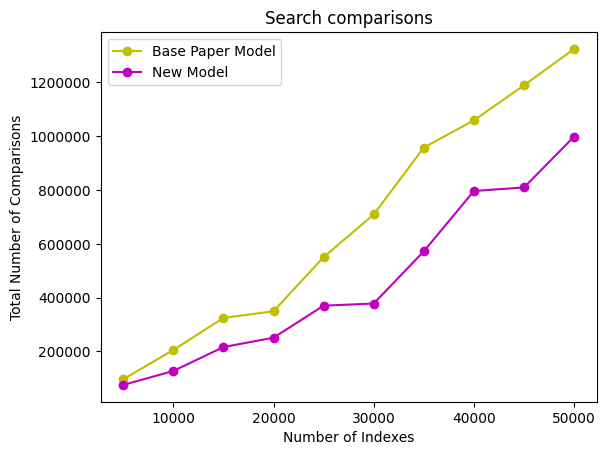

In [198]:
x12 = [d[0] for d in old_model_search_table]
y12 = [d[1] for d in old_model_search_table]
x22 = [d[0] for d in new_model_search_table]
y22 = [d[1] for d in new_model_search_table]
x32 = [d[0] for d in classic_treap_search_table]
y32 = [d[1] for d in classic_treap_search_table]

plt.plot(x12, y12,  "-yo", label='Base Paper Model')
plt.plot(x22, y22, "-mo", label='New Model')

plt.xlabel('Number of Indexes')
plt.ylabel('Total Number of Comparisons')
plt.title('Search comparisons')
plt.ticklabel_format(style='plain', axis='y')

plt.legend()

plt.show()

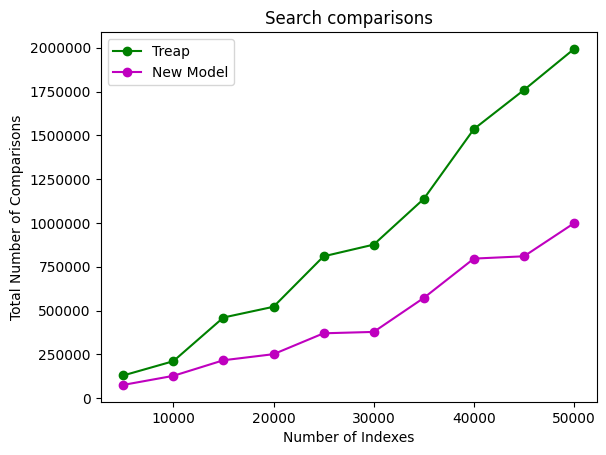

In [199]:
plt.plot(x32, y32, "-go",   label='Treap')
plt.plot(x22, y22, "-mo",   label='New Model')

plt.xlabel('Number of Indexes')
plt.ylabel('Total Number of Comparisons')
plt.title('Search comparisons')
plt.ticklabel_format(style='plain', axis='y')

plt.legend()

plt.show()

In [103]:
delete_list1 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:2500].index.to_list()
delete_list2 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:5000].index.to_list()
delete_list3 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:7500].index.to_list()
delete_list4 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:10000].index.to_list()
delete_list5 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:12500].index.to_list()
delete_list6 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:15000].index.to_list()
delete_list7 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:17500].index.to_list()
delete_list8 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:20000].index.to_list()
delete_list9 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:22500].index.to_list()
delete_list10 = aol_frequency_test.sort_values(by="freq" , ascending=True)[:25000].index.to_list()

In [104]:
old_treap_delete1 = 0
old_treap_delete2 = 0
old_treap_delete3 = 0
old_treap_delete4 = 0
old_treap_delete5 = 0
old_treap_delete6 = 0
old_treap_delete7 = 0
old_treap_delete8 = 0
old_treap_delete9 = 0
old_treap_delete10 = 0

In [105]:
old_model_delete_table = []
for element in delete_list1:
    old_model_treap1.delete(element)
    old_treap_delete1 += old_model_treap1.comparisons_delete
old_model_delete_table.append([len(delete_list1), old_treap_delete1])
for element in delete_list2:
    old_model_treap2.delete(element)
    old_treap_delete2 += old_model_treap2.comparisons_delete
old_model_delete_table.append([len(delete_list2), old_treap_delete2])
for element in delete_list3:
    old_model_treap3.delete(element)
    old_treap_delete3 += old_model_treap3.comparisons_delete
old_model_delete_table.append([len(delete_list3), old_treap_delete3])
for element in delete_list4:
    old_model_treap4.delete(element)
    old_treap_delete4 += old_model_treap4.comparisons_delete
old_model_delete_table.append([len(delete_list4), old_treap_delete4])
for element in delete_list5:
    old_model_treap5.delete(element)
    old_treap_delete5 += old_model_treap5.comparisons_delete
old_model_delete_table.append([len(delete_list5), old_treap_delete5])
for element in delete_list6:
    old_model_treap6.delete(element)
    old_treap_delete6 += old_model_treap6.comparisons_delete
old_model_delete_table.append([len(delete_list6), old_treap_delete6])
for element in delete_list7:
    old_model_treap7.delete(element)
    old_treap_delete7 += old_model_treap7.comparisons_delete
old_model_delete_table.append([len(delete_list7), old_treap_delete7])
for element in delete_list8:
    old_model_treap8.delete(element)
    old_treap_delete8 += old_model_treap8.comparisons_delete
old_model_delete_table.append([len(delete_list8), old_treap_delete8])
for element in delete_list9:
    old_model_treap9.delete(element)
    old_treap_delete9 += old_model_treap9.comparisons_delete
old_model_delete_table.append([len(delete_list9), old_treap_delete9])
for element in delete_list10:
    old_model_treap10.delete(element)
    old_treap_delete10 += old_model_treap10.comparisons_delete
old_model_delete_table.append([len(delete_list10), old_treap_delete10])

In [106]:
new_treap_delete1 = 0
new_treap_delete2 = 0
new_treap_delete3 = 0
new_treap_delete4 = 0
new_treap_delete5 = 0
new_treap_delete6 = 0
new_treap_delete7 = 0
new_treap_delete8 = 0
new_treap_delete9 = 0
new_treap_delete10 = 0

In [107]:
new_model_delete_table = []
for element in delete_list1:
    new_model_treap1.delete(element)
    new_treap_delete1 += new_model_treap1.comparisons_delete
new_model_delete_table.append([len(delete_list1), new_treap_delete1])
for element in delete_list2:
    new_model_treap2.delete(element)
    new_treap_delete2 += new_model_treap2.comparisons_delete
new_model_delete_table.append([len(delete_list2), new_treap_delete2])
for element in delete_list3:
    new_model_treap3.delete(element)
    new_treap_delete3 += new_model_treap3.comparisons_delete
new_model_delete_table.append([len(delete_list3), new_treap_delete3])
for element in delete_list4:
    new_model_treap4.delete(element)
    new_treap_delete4 += new_model_treap4.comparisons_delete
new_model_delete_table.append([len(delete_list4), new_treap_delete4])
for element in delete_list5:
    new_model_treap5.delete(element)
    new_treap_delete5 += new_model_treap5.comparisons_delete
new_model_delete_table.append([len(delete_list5), new_treap_delete5])
for element in delete_list6:
    new_model_treap6.delete(element)
    new_treap_delete6 += new_model_treap6.comparisons_delete
new_model_delete_table.append([len(delete_list6), new_treap_delete6])
for element in delete_list7:
    new_model_treap7.delete(element)
    new_treap_delete7 += new_model_treap7.comparisons_delete
new_model_delete_table.append([len(delete_list7), new_treap_delete7])
for element in delete_list8:
    new_model_treap8.delete(element)
    new_treap_delete8 += new_model_treap8.comparisons_delete
new_model_delete_table.append([len(delete_list8), new_treap_delete8])
for element in delete_list9:
    new_model_treap9.delete(element)
    new_treap_delete9 += new_model_treap9.comparisons_delete
new_model_delete_table.append([len(delete_list9), new_treap_delete9])
for element in delete_list10:
    new_model_treap10.delete(element)
    new_treap_delete10 += new_model_treap10.comparisons_delete
new_model_delete_table.append([len(delete_list10), new_treap_delete10])

In [108]:
classic_treap_delete1 = 0
classic_treap_delete2 = 0
classic_treap_delete3 = 0
classic_treap_delete4 = 0
classic_treap_delete5 = 0
classic_treap_delete6 = 0
classic_treap_delete7 = 0
classic_treap_delete8 = 0
classic_treap_delete9 = 0
classic_treap_delete10 = 0

In [109]:
classic_treap_delete_table = []
for element in delete_list1:
    classic_treap1.delete(element)
    new_treap_delete1 += classic_treap1.comparisons_delete
classic_treap_delete_table.append([len(delete_list1), new_treap_delete1])
for element in delete_list2:
    classic_treap2.delete(element)
    new_treap_delete2 += classic_treap2.comparisons_delete
classic_treap_delete_table.append([len(delete_list2), new_treap_delete2])
for element in delete_list3:
    classic_treap3.delete(element)
    new_treap_delete3 += classic_treap3.comparisons_delete
classic_treap_delete_table.append([len(delete_list3), new_treap_delete3])
for element in delete_list4:
    classic_treap4.delete(element)
    new_treap_delete4 += classic_treap4.comparisons_delete
classic_treap_delete_table.append([len(delete_list4), new_treap_delete4])
for element in delete_list5:
    classic_treap5.delete(element)
    new_treap_delete5 += classic_treap5.comparisons_delete
classic_treap_delete_table.append([len(delete_list5), new_treap_delete5])
for element in delete_list6:
    classic_treap6.delete(element)
    new_treap_delete6 += classic_treap6.comparisons_delete
classic_treap_delete_table.append([len(delete_list6), new_treap_delete6])
for element in delete_list7:
    classic_treap7.delete(element)
    new_treap_delete7 += classic_treap7.comparisons_delete
classic_treap_delete_table.append([len(delete_list7), new_treap_delete7])
for element in delete_list8:
    classic_treap8.delete(element)
    new_treap_delete8 += classic_treap8.comparisons_delete
classic_treap_delete_table.append([len(delete_list8), new_treap_delete8])
for element in delete_list9:
    classic_treap9.delete(element)
    new_treap_delete9 += classic_treap9.comparisons_delete
classic_treap_delete_table.append([len(delete_list9), new_treap_delete9])
for element in delete_list10:
    classic_treap10.delete(element)
    new_treap_delete10 += classic_treap10.comparisons_delete
classic_treap_delete_table.append([len(delete_list10), new_treap_delete10])

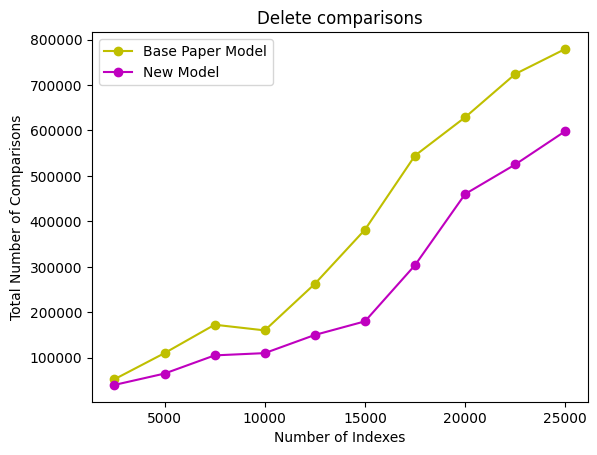

In [200]:
x13 = [d[0] for d in old_model_delete_table]
y13 = [d[1] for d in old_model_delete_table]
x23 = [d[0] for d in new_model_delete_table]
y23 = [d[1] for d in new_model_delete_table]
x33 = [d[0] for d in classic_treap_delete_table]
y33 = [d[1] for d in classic_treap_delete_table]

plt.plot(x13, y13, "-yo",label='Base Paper Model')
plt.plot(x23, y23,"-mo", label='New Model')

plt.xlabel('Number of Indexes')
plt.ylabel('Total Number of Comparisons')
plt.title('Delete comparisons')
plt.ticklabel_format(useOffset=False)

plt.legend()

plt.show()

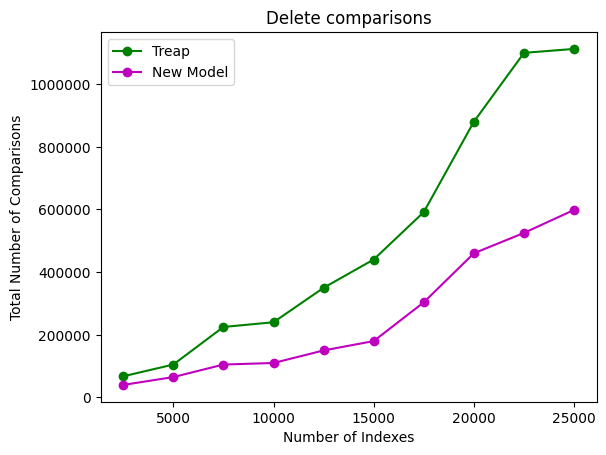

In [202]:
plt.plot(x33, y33, "-go", label='Treap')
plt.plot(x23, y23, "-mo",label='New Model')

plt.xlabel('Number of Indexes')
plt.ylabel('Total Number of Comparisons')
plt.title('Delete comparisons')
plt.ticklabel_format(style='plain', axis='y')

plt.legend()

plt.show()

In [137]:
from texttable import Texttable
t = Texttable()
t.add_row(['Data Structure', 'Operation', 'Number of Indexes', 'Average Comparisons'])

In [138]:
for x,y in old_treap_table:
    t.add_row(["Learning Augmented Treap(Old model)", "Insertion", x, y/x])

In [140]:
for x,y in new_treap_table:
    t.add_row(["Learning Augmented Treap(New model)", "Insertion", x, y/x])

In [141]:
for x,y in classic_treap_table:
    t.add_row(["Classic Treap", "Insertion", x, y/x])

In [142]:
print(t.draw())

+------------------------+-----------+-------------------+---------------------+
| Data Structure         | Operation | Number of Indexes | Average Comparisons |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Insertion | 10000             | 15.714              |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Insertion | 20000             | 17.180              |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Insertion | 30000             | 17.906              |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | I

In [143]:
t1 = Texttable()
t1.add_row(['Data Structure', 'Operation', 'Number of Indexes', 'Average Comparisons'])

In [144]:
for x,y in old_model_search_table:
    t1.add_row(["Learning Augmented Treap(Old model)", "Search", x, y/x])

In [145]:
for x,y in new_model_search_table:
    t1.add_row(["Learning Augmented Treap(New model)", "Search", x, y/x])

In [146]:
for x,y in classic_treap_search_table:
    t1.add_row(["Classic Treap", "Search", x, y/x])

In [147]:
print(t1.draw())

+------------------------+-----------+-------------------+---------------------+
| Data Structure         | Operation | Number of Indexes | Average Comparisons |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Search    | 5000              | 19.261              |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Search    | 10000             | 20.516              |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Search    | 15000             | 21.631              |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | S

In [155]:
t2 = Texttable()
t2.add_row(['Data Structure', 'Operation', 'Number of Indexes', 'Average Comparisons'])

In [156]:
for x,y in old_model_delete_table:
    t2.add_row(["Learning Augmented Treap(Old model)", "Deletion", x, y/x])

In [157]:
for x,y in new_model_delete_table:
    t2.add_row(["Learning Augmented Treap(New model)", "Deletion", x, y/x])

In [158]:
for x,y in classic_treap_delete_table:
    t2.add_row(["Classic Treap", "Deletion", x, y/x])

In [159]:
print(t2.draw())

+------------------------+-----------+-------------------+---------------------+
| Data Structure         | Operation | Number of Indexes | Average Comparisons |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Deletion  | 2500              | 21                  |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Deletion  | 5000              | 22                  |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | Deletion  | 7500              | 23                  |
| Treap(Old model)       |           |                   |                     |
+------------------------+-----------+-------------------+---------------------+
| Learning Augmented     | D